# Exploring Gene Expression Data

**(first part) adapted from**: [Elegant SciPy](https://github.com/elegant-scipy/notebooks/blob/master/notebooks/ch1.ipynb)

The DNA is *transcribed* into a sister molecule called *messenger ribonucleic acid*, or `mRNA`.

As stated in the **central dogma** (see picture below $\Downarrow$), `mRNA` is *translated* into proteins, the workhorses of the cell.
A section of DNA that encodes the information to make a protein (via mRNA) is called a **gene**.

The amount of `mRNA` produced from a given gene is called the *expression* of that gene.

<img src="https://raw.githubusercontent.com/elegant-scipy/notebooks/master/figures/central_dogma.png"/>

Although we would ideally like to measure protein levels, this is a much harder task than measuring `mRNA`.

Fortunately, expression levels of an `mRNA` and levels of its corresponding protein are usually correlated.[$^{Maier}$](#fnmaier)

Therefore, we usually measure `mRNA` levels and base our analyses on that.

<span id="fnmaier"><i>[Maier]</i>: Tobias Maier, Marc Güell, and Luis Serrano. ["Correlation of mRNA and protein in complex biological samples"](http://www.sciencedirect.com/science/article/pii/S0014579309008126), FEBS Letters 583, no. 204 (2009).</span>


It is important to **emphasise** that the `DNA` in every cell of our body is identical.

Thus, the differences between cells arise from **differential expression** of
that DNA into RNA: in different cells, different parts of the DNA are processed
into downstream molecules.

Similarly, differential expression can distinguish different kinds of cancer.

![](https://raw.githubusercontent.com/elegant-scipy/notebooks/master/figures/differential_gene_expression.png)

###### State-of-the-art Technology
The state-of-the-art technology to measure `mRNA` is **RNA sequencing** (`RNAseq`).

`RNA` is extracted from a tissue sample (e.g., from a biopsy from a patient), *reverse transcribed* back into `DNA` (which is more stable), and then read out using chemically modified bases that glow when they are incorporated into the DNA sequence.

Currently, **high-throughput sequencing** machines can only read short fragments. 

These short sequences are called `reads`.

We measure millions of reads and then based on their sequence we count how many reads came from each gene.

We’ll be starting our analysis directly from this count data.

![](https://raw.githubusercontent.com/elegant-scipy/notebooks/master/figures/RNAseq.png)
<!-- caption text="RNA sequencing (RNAseq)" -->

This table shows a minimal example of gene expression count data:

|        | Cell type A | Cell type B |
|--------|-------------|-------------|
| Gene 0 | 100         | 200         |
| Gene 1 | 50          | 0           |
| Gene 2 | 350         | 100         |

The data is a table of counts, integers representing how many reads were observed for each gene in each cell type.

#### Exploring a Gene Expression Dataset

The dataset that we'll be using is an RNAseq experiment of skin cancer samples from 
**The Cancer Genome Atlas** (TCGA) project (http://cancergenome.nih.gov/).

In the next part of this notebook, we will be using this gene expression data to predict mortality in skin cancer patients, reproducing a simplified version of [Figures 5A and 5B](http://www.cell.com/action/showImagesData?pii=S0092-8674%2815%2900634-0) of a [paper](http://dx.doi.org/10.1016/j.cell.2015.05.044) from the TCGA consortium.

<img src="imgs/tcga_paper.png" />

In [1]:
## Reading Data
import numpy as np
import pandas as pd

# Import TCGA melanoma data
filename = 'tcga/counts.txt'
data_table = pd.read_csv(filename, index_col=0) # Parse file with pandas

In [2]:
data_table.head(n=15)

,00624286-41dd-476f-a63b-d2a5f484bb45,TCGA-FS-A1Z0,TCGA-D9-A3Z1,02c76d24-f1d2-4029-95b4-8be3bda8fdbe,TCGA-EB-A51B,TCGA-D3-A1Q3,TCGA-FR-A44A,TCGA-EE-A17Z,TCGA-D3-A51G,TCGA-D3-A51E,...,TCGA-D9-A149,TCGA-EE-A3AG,TCGA-D9-A4Z2,TCGA-EB-A4OZ,TCGA-EE-A3J4,TCGA-FS-A1ZM,TCGA-D3-A5GS,TCGA-EB-A3XF,TCGA-EE-A2GE,ff7431a9-243a-4651-80bb-096379925bbe
A1BG,1272.36,452.96,288.06,400.11,420.46,877.59,402.77,559.20,269.59,586.66,...,631.78,560.60,846.55,678.00,32.88,997.41,256.93,461.60,634.06,530.36
A1CF,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
A2BP1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00
A2LD1,164.38,552.43,201.83,165.12,95.75,636.63,241.56,30.82,105.44,239.19,...,218.47,274.45,770.04,71.74,17.00,194.26,156.81,84.35,242.01,377.03
A2ML1,27.00,0.00,0.00,0.00,8.00,0.00,1.00,763.00,0.00,0.00,...,3.00,6.00,0.00,1043.00,1.00,852.00,4.00,587.00,0.00,2.00
A2M,65232.35,61911.87,99195.94,12880.89,83380.84,39417.73,358068.86,16470.99,320261.89,162625.78,...,22861.93,28221.61,87252.65,9300.02,103333.98,1222615.54,70911.72,85091.90,253599.66,71228.78
A4GALT,190.00,213.00,103.00,752.00,38.00,301.00,424.00,97.00,693.00,99.00,...,160.00,1020.00,177.00,369.00,99.00,422.00,154.00,81.00,1210.00,380.00
A4GNT,5.00,0.00,1.00,1.00,0.00,3.00,2.00,0.00,20.00,3.00,...,1.00,1.00,6.00,0.00,0.00,8.00,1.00,0.00,2.00,1.00
AAA1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AAAS,2449.00,2181.00,1203.00,1440.00,1646.00,3353.00,2422.00,1357.00,1617.00,2097.00,...,3484.00,5248.00,3275.00,1798.00,2325.00,2784.00,2430.00,1932.00,2613.00,2243.00


In [3]:
genes_file = 'tcga/genes.csv'
gene_info = pd.read_csv(genes_file, index_col=0)

In [4]:
gene_info.head(n=15)

,GeneID,GeneLength
GeneSymbol,,
CPA1,1357,1724
GUCY2D,3000,3623
UBC,7316,2687
C11orf95,65998,5581
ANKMY2,57037,2611
C17orf81,23587,2399
TTC36,143941,814
IQCD,115811,2367
HSPA13,6782,3984


Let's check how well our gene length data matches up with our count data.

In [5]:
print("Genes in data_table: ", data_table.shape[0])
print("Genes in gene_info: ", gene_info.shape[0])

Genes in data_table:  20500
Genes in gene_info:  20503


There are more genes in our gene length data than were actually measured in the experiment.

Let's filter so we only get the relevant genes, and we want to make sure they are in the same order as in our count data.

In [6]:
matched_index = pd.Index.intersection(data_table.index, gene_info.index)

# 2D ndarray containing expression counts for each gene in each individual
counts = np.asarray(data_table.loc[matched_index], dtype=int)

gene_names = np.array(matched_index)

In [7]:
print('{} genes measured in {} individuals.'.format(counts.shape[0], 
                                                    counts.shape[1]))

20500 genes measured in 375 individuals.


In [8]:
# gene lengths
# 1D ndarray containing the lengths of each gene
gene_lengths = np.asarray(gene_info.loc[matched_index]['GeneLength'],
                          dtype=int)

In [9]:
print(counts.shape)
print(gene_lengths.shape)

(20500, 375)
(20500,)


#### Data Normalisation

Real world data contains all kinds of measurement artifacts.

Before doing any kind of analysis with it, it is important to take a look at it to determine whether some normalization is warranted.

In our case, we want to make sure that any differences we uncover correspond to real biological differences, and not to technical artifact.

We will consider two levels of normalization often applied jointly to gene
expression dataset: 

* normalization between samples (columns);
* normalization between genes (rows).

##### Normalisation between Samples (i.e. columns)

The number of counts for each individual can vary substantially in RNAseq experiments.

Let's take a look at the distribution of expression counts over all the genes.

First, we will sum the columns to get the total counts of expression of all genes for each individual, so we can just look at the variation between individuals.

To visualize the distribution of total counts, we will use 
**kernel density estimation** (KDE), a technique commonly used to smooth out histograms because it gives a clearer picture of the underlying distribution.

In [10]:
# Make all plots appear inline in the Jupyter notebook from now onwards
%matplotlib inline
# Use our own style file for the plots
import matplotlib.pyplot as plt
# plt.style.use('style/elegant.mplstyle')

from scipy import stats

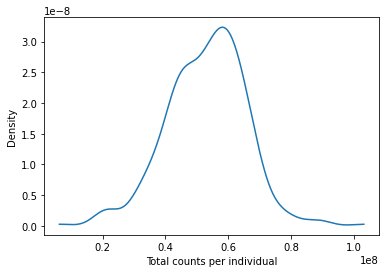

Count statistics: 
  Total Counts:  (375,)
  min:  6231205
  mean: 52995255.33866667
  max:  103219262


In [11]:
total_counts = np.sum(counts, axis=0)  # sum columns together
                                       # (axis=1 would sum rows)

# Use Gaussian smoothing to estimate the density
density = stats.kde.gaussian_kde(total_counts)

# Make values for which to estimate the density, for plotting
x = np.arange(min(total_counts), max(total_counts), 10000)

# Make the density plot
fig, ax = plt.subplots()
ax.plot(x, density(x))
ax.set_xlabel("Total counts per individual")
ax.set_ylabel("Density")

plt.show()

print('Count statistics: '
      '\n  Total Counts:  {tc}'
      '\n  min:  {min}'
      '\n  mean: {mean}'
      '\n  max:  {max}'.format(min=np.min(total_counts),
                               mean=np.mean(total_counts),
                               max=np.max(total_counts),
                               tc=total_counts.shape))

We can observe that there is an order of magnitude difference in the total number of counts between the lowest and the highest individual.

This means that a different number of RNAseq reads were generated for each individual.

We say that these individuals have different **library sizes**.

##### Normalizing library size between samples

Let's take a closer look at ranges of gene expression for each individual, so when
we apply our normalization we can see it in action. 

We'll subset a random sample of just 70 columns to keep the plotting from getting too messy.

In [12]:
# Subset data for plotting
np.random.seed(seed=7) # Set seed so we will get consistent results
# Randomly select 70 samples
samples_index = np.random.choice(range(counts.shape[1]), 
                                 size=70, replace=False)
counts_subset = counts[:, samples_index]

In [13]:
from boxplot import reduce_xaxis_labels

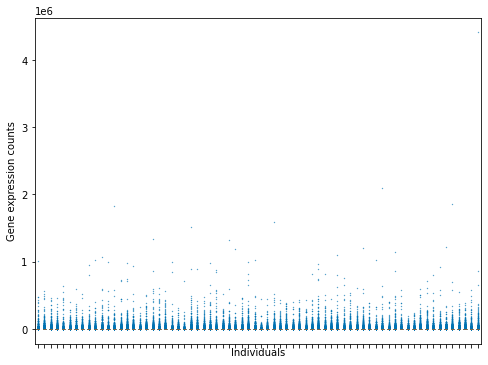

In [14]:
# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(8, 6))

with plt.style.context('style/thinner.mplstyle'):
    ax.boxplot(counts_subset)
    ax.set_xlabel("Individuals")
    ax.set_ylabel("Gene expression counts")
    reduce_xaxis_labels(ax, 5)

There are obviously a lot of outliers at the high expression end of the scale and a lot of variation between individuals, but these are hard to see because everything is clustered around zero.

So let's do $log(n + 1)$ of our data so it's a bit easier to look at.

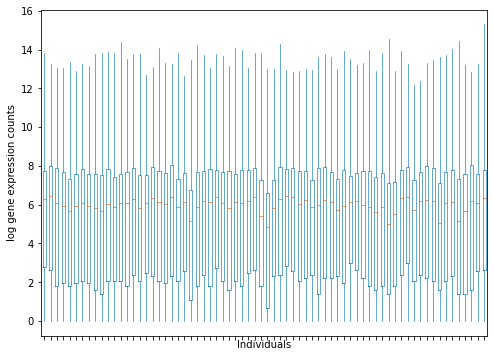

In [15]:
# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(8, 6))

with plt.style.context('style/thinner.mplstyle'):
    ax.boxplot(np.log(counts_subset + 1))
    ax.set_xlabel("Individuals")
    ax.set_ylabel("log gene expression counts")
    reduce_xaxis_labels(ax, 5)

Now let's see what happens when we normalize by library size.

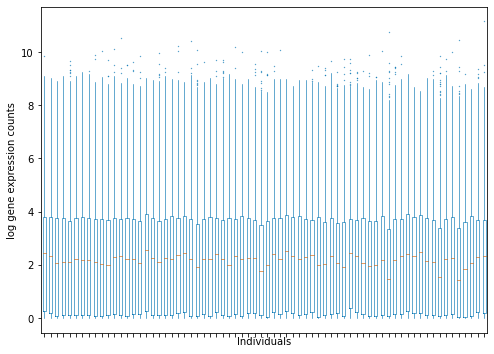

In [16]:
# Normalize by library size
# Divide the expression counts by the total counts for that individual
# Multiply by 1 million to get things back in a similar scale
counts_lib_norm = counts / total_counts * 1000000
# Notice how we just used broadcasting twice there!
counts_subset_lib_norm = counts_lib_norm[:,samples_index]

# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(8, 6))

with plt.style.context('style/thinner.mplstyle'):
    ax.boxplot(np.log(counts_subset_lib_norm + 1))
    ax.set_xlabel("Individuals")
    ax.set_ylabel("log gene expression counts")
    reduce_xaxis_labels(ax, 5)

In [17]:
from boxplot import class_boxplot

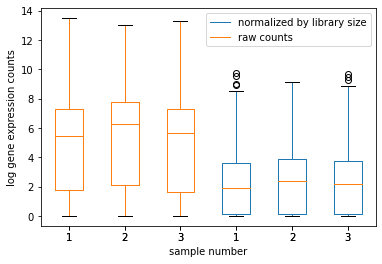

In [18]:
log_counts_3 = list(np.log(counts.T[:3] + 1))
log_ncounts_3 = list(np.log(counts_lib_norm.T[:3] + 1))
ax = class_boxplot(log_counts_3 + log_ncounts_3,
                   ['raw counts'] * 3 + ['normalized by library size'] * 3,
                   labels=[1, 2, 3, 1, 2, 3])
ax.set_xlabel('sample number')
ax.set_ylabel('log gene expression counts');

##### Normalisation between Genes (i.e. Rows)

We can also get into some trouble when trying to compare different genes.

The number of counts for a gene is related to the gene length.

Suppose `gene B` is twice as long as `gene A`.

Both are expressed at similar levels in the sample (i.e., both produce a similar number of _mRNA_ molecules).

In _RNAseq_ experiment, we fragment the transcripts, and sample reads from that pool of fragments.

So if a gene is twice as long, it'll produce twice as many fragments, and we are twice as likely to sample it.

Therefore, we would expect `gene B` to have about twice as many counts as `gene A`.

If we want to compare the expression levels of different genes, we will have to do some more normalization.

<img src="https://raw.githubusercontent.com/elegant-scipy/notebooks/c7f4cc84deaceb132cf697ae359e75ff4881590b/figures/gene_length_counts.png"/>

Let's see if the relationship between gene length and counts plays out in our dataset.

In [19]:
from boxplot import binned_boxplot

We now compute the gene lengths and counts:

In [20]:
log_counts = np.log(counts_lib_norm + 1)
mean_log_counts = np.mean(log_counts, axis=1)  # across samples
log_gene_lengths = np.log(gene_lengths)

And we plot the counts as a function of gene length:

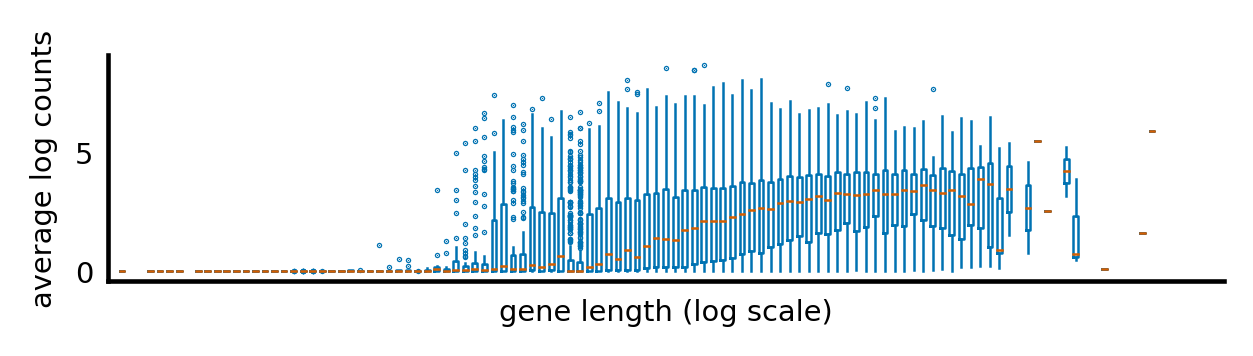

In [21]:
with plt.style.context('style/thinner.mplstyle'):
    binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

We can see in the previous image that the longer a gene is, the higher its measured counts!

As previously explained, this is an artifact of the technique, not a biological signal!

#### Normalizing Over Samples and Genes: RPKM

One of the simplest normalization methods for RNAseq data is RPKM: reads per
kilobase transcript per million reads.

RPKM puts together the ideas of normalizing by sample and by gene.

When we calculate RPKM, we are normalizing for both the **library size** (the sum of each column)
and the **gene length**.

To work through how RPKM is derived, let's define the following values:

- $C$ = Number of reads mapped to a gene
- $L$ = Exon length in base-pairs for a gene
- $N$ = Total mapped reads in the experiment

First, let's calculate `reads per kilobase`.

Reads per base would be:
$\frac{C}{L}$

The formula asks for reads per kilobase instead of reads per base.
One kilobase = 1,000 bases, so we'll need to divide length (L) by 1,000.

Reads per kilobase would be:

$\frac{C}{L/1000}  = \frac{10^3C}{L}$

Next, we need to normalize by library size.
If we just divide by the number of mapped reads we get:

$ \frac{10^3C}{LN} $

But biologists like thinking in millions of reads so that the numbers don't get
too big. Counting per million reads we get:

$ \frac{10^3C}{L(N/10^6)} = \frac{10^9C}{LN}$


In summary, to calculate reads per kilobase transcript per million reads:
$RPKM = \frac{10^9C}{LN}$

Now let's implement RPKM over the entire counts array.

In [22]:
# Make our variable names the same as the RPKM formula so we can compare easily
C = counts
N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
L = gene_lengths  # lengths for each gene, matching rows in `C`

In [23]:
def rpkm(counts, lengths):
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return(normed)

In [24]:
counts_rpkm = rpkm(counts, gene_lengths)

Let's visualise RPKM Normalisation effect on our data (if any) :)

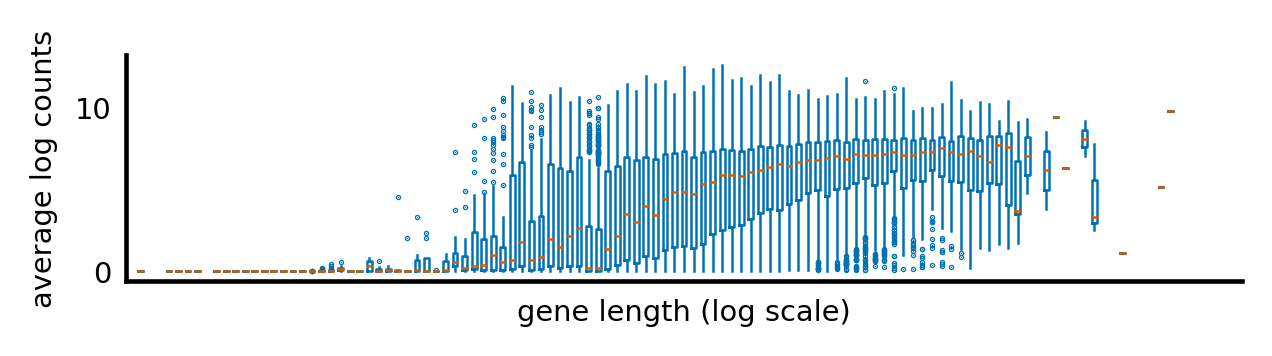

In [25]:
log_counts = np.log(counts + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)

with plt.style.context('style/thinner.mplstyle'):
    binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

Now, the same plot with the RPKM-normalized values

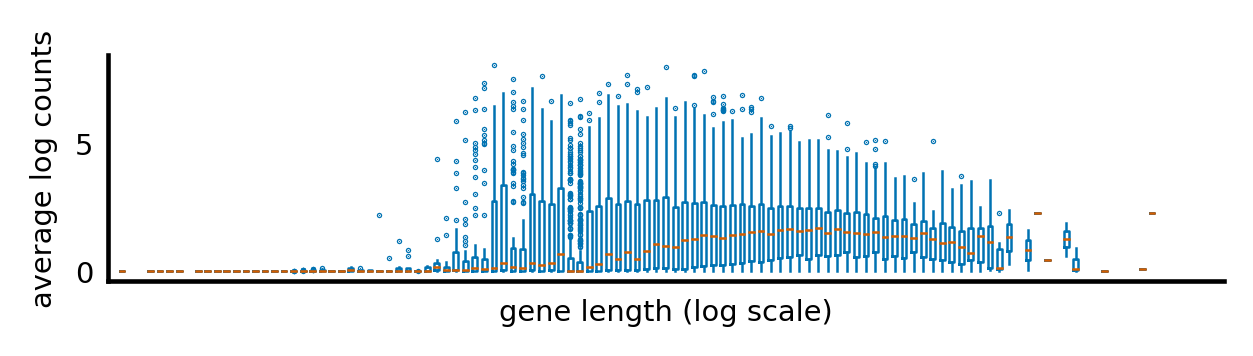

In [26]:
log_counts = np.log(counts_rpkm + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)

with plt.style.context('style/thinner.mplstyle'):
    binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

**RPKM** normalization can be useful to compare the expression profile of different genes.

We've already seen that longer genes have higher counts, but this doesn't mean their expression level is actually higher.

Let's choose a short gene and a long gene and compare their counts before and after RPKM normalization to see what we mean.

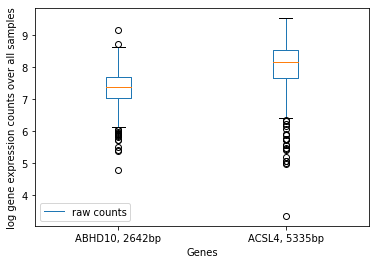

In [27]:
gene_idxs = np.array([80, 186])
gene1, gene2 = gene_names[gene_idxs]
len1, len2 = gene_lengths[gene_idxs]
gene_labels = ['{gene1}, {len1}bp'.format(gene1=gene1, len1=len1), 
               '{gene2}, {len2}bp'.format(gene2=gene2, len2=len2)]

log_counts = list(np.log(counts[gene_idxs] + 1))
log_ncounts = list(np.log(counts_rpkm[gene_idxs] + 1))

ax = class_boxplot(log_counts,
                   ['raw counts'] * 3,
                   labels=gene_labels)
ax.set_xlabel('Genes')
ax.set_ylabel('log gene expression counts over all samples');

However, after RPKM normalization, a different picture emerges:

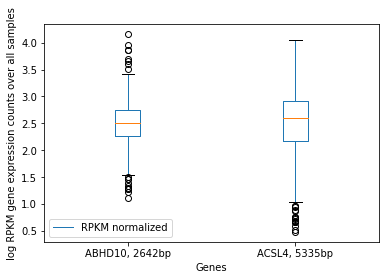

In [28]:
ax = class_boxplot(log_ncounts,
                   ['RPKM normalized'] * 3,
                   labels=gene_labels)
ax.set_xlabel('Genes')
ax.set_ylabel('log RPKM gene expression counts over all samples');

RPKM includes normalization for gene length, so we can now directly compare between genes of different lengths.

---

## Predicting Survival

We now want to use each patient's *gene expression profile* (the full vector of their gene expression measurements) to predict their expected survival.

In order to use full profiles, we need a stronger normalization than `RPKM` provides.

We will instead perform [*quantile normalization*](https://en.wikipedia.org/wiki/Quantile_normalization), a technique that ensures measurements fit a specific distribution.

This method enforces a strong assumption: if the data are not distributed according to a desired shape, we just make it fit!

Bolstad and colleagues [showed](https://doi.org/10.1093/bioinformatics/19.2.185) that it performs admirably in recovering known expression levels in microarray data.

<img src="imgs/paper_quantization.png" width="90%" />

#### Note

Due to the kind of variability of gene expression count data, it is common practice to log-transform the data before quantile-normalizing.

In [29]:
from quantile_normalisation import quantile_norm_log

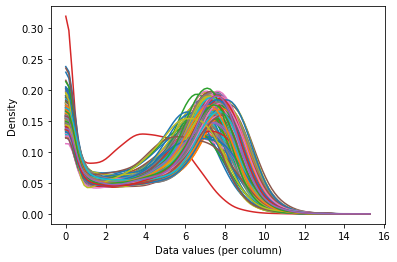

In [30]:
from scipy import stats

def plot_col_density(data):
    """For each column, produce a density plot over all rows."""

    # Use Gaussian smoothing to estimate the density
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per column)')
    ax.set_ylabel('Density')
    
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

Now, let's see what our distributions look like after quantile normalization.

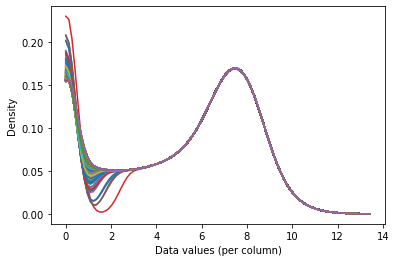

In [31]:
# After normalization
log_counts_normalized = quantile_norm_log(counts)

plot_col_density(log_counts_normalized)

Now that we have normalized our counts, we can start using our gene expression data to predict patient prognosis.

#### Bicluster

Clustering the samples tells us which samples have similar gene expression profiles, which may indicate similar characteristics of the samples on other scales.

Now that the data are normalized, we can cluster the genes (rows) and samples (columns) of the expression matrix.

Clustering the rows tells us which genes' expression values are linked, which is an indication that they work together in the process being studied.

*Biclustering* means that we are simultaneously clustering both the rows and columns of our data.

By clustering along the rows we find out with genes are working together, and by clustering along the columns we find out which samples are similar.

Because clustering can be an expensive operation, we will limit our analysis to the 1,500 genes that are most variable, since these will account for most of the correlation signal in either dimension.

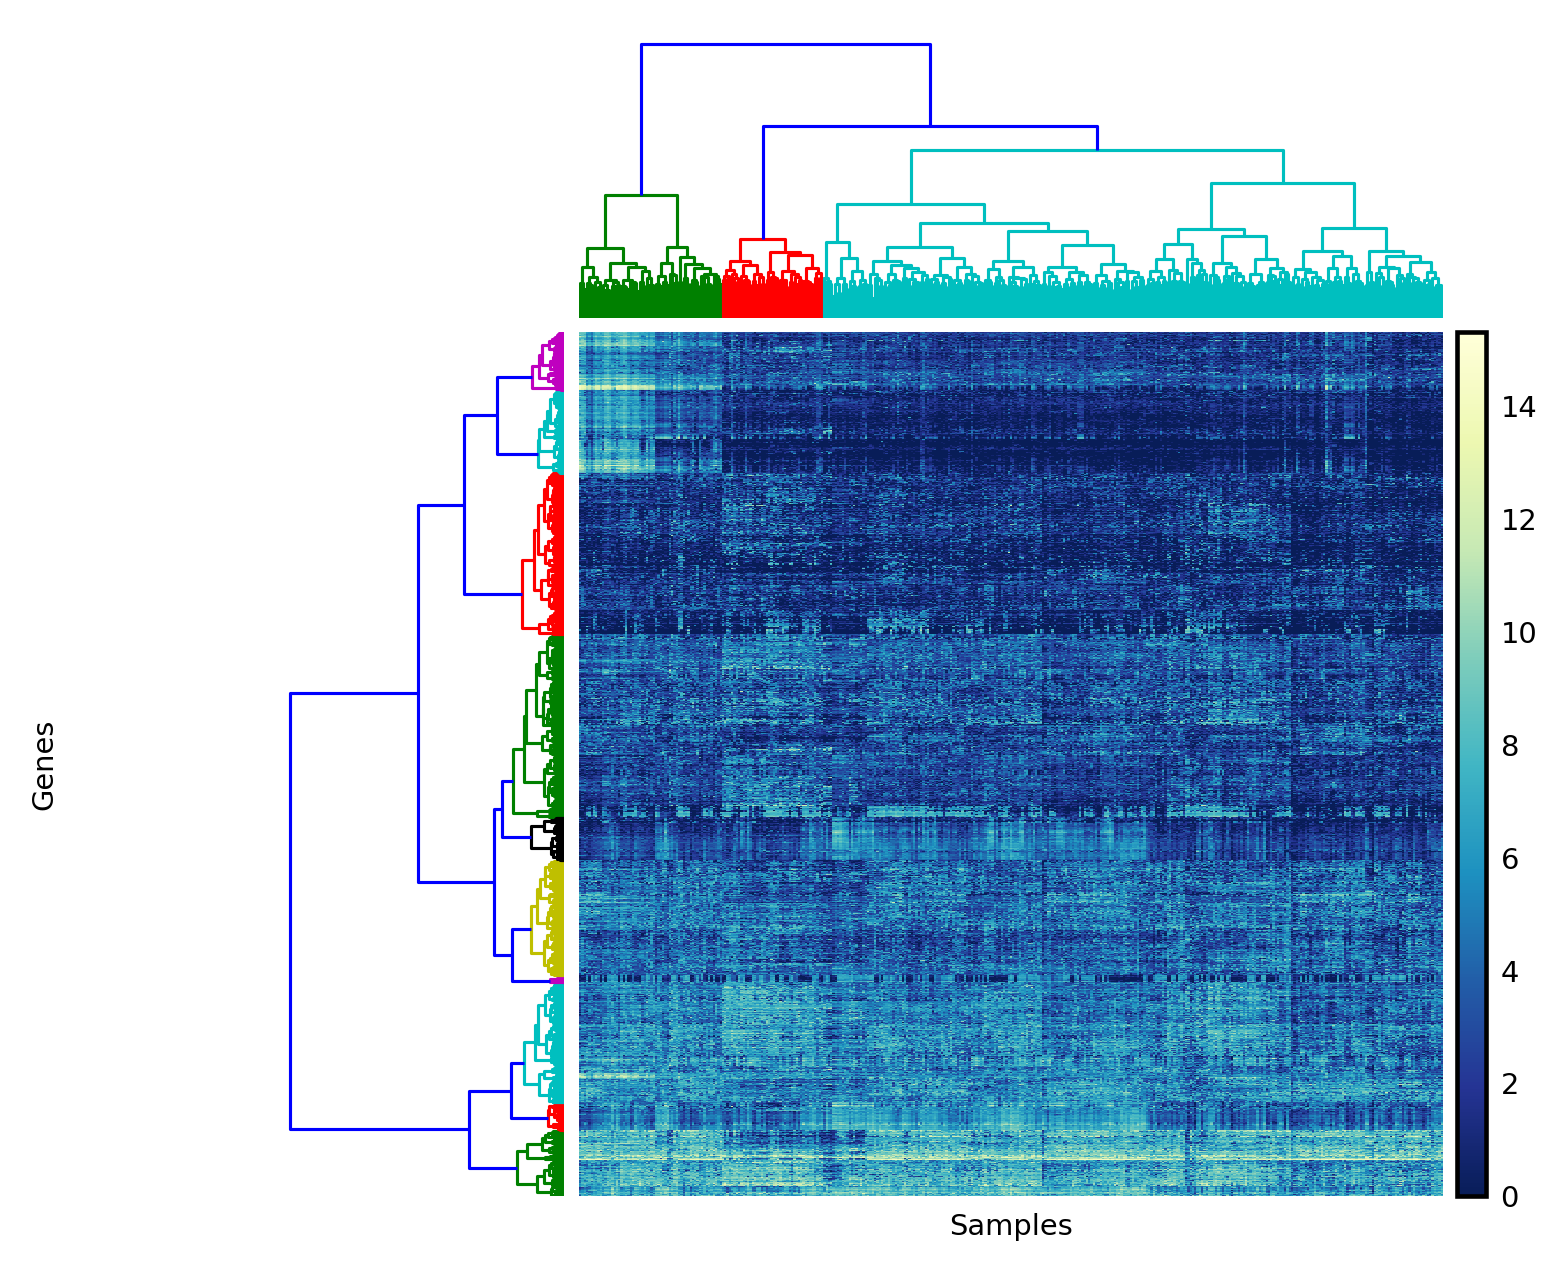

In [32]:
from bicluster import bicluster, plot_bicluster, most_variable_rows

counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
                   distance_metric='euclidean')
with plt.style.context('style/thinner.mplstyle'):
    plot_bicluster(counts_var, yr, yc)

We can see that the sample data naturally falls into at least two clusters, maybe three.

Are these clusters meaningful?

To answer this, we can access the patient data, available from the [data repository](https://tcga-data.nci.nih.gov/docs/publications/skcm_2015/) for the paper.

After some preprocessing, we get the [patients table](https://github.com/elegant-scipy/elegant-scipy/blob/master/data/patients.csv), which contains survival information for each patient.

We can then match these to the counts clusters, and understand whether the patients' gene expression can predict differences in their pathology.

In [33]:
patients = pd.read_csv('tcga/patients.csv', index_col=0)
patients.head(n=20)

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0
TCGA-BF-A3DJ,UV signature,keratin,NaN,NaN
TCGA-BF-A3DL,UV signature,keratin,NaN,NaN
TCGA-BF-A3DM,UV signature,MITF-low,NaN,NaN
TCGA-BF-A3DN,UV signature,MITF-low,NaN,NaN
TCGA-BF-A5EO,UV signature,keratin,NaN,NaN


In [34]:
patients.columns

Index(['UV-signature', 'original-clusters', 'melanoma-survival-time',
       'melanoma-dead'],
      dtype='object')

### Description

For each patient (the rows) we have:

- UV­ signature: Ultraviolet light tends to cause specific DNA mutations.
By looking for this mutation signature researchers can infer whether UV light likely caused the mutation(s) that led to cancer in these patients.

- original­ clusters: In the paper, the patients were clustered using gene expression data.
These clusters were classified according to the types of genes that typified that cluster.
The main clusters were "immune" (n = 168; 51%), "keratin" (n = 102; 31%), and "MITF-low" (n = 59; 18%).

- melanoma­ survival­ time: Number of days that the patient survived.

- melanoma­ dead: 1 if the patient died of melanoma, 0 if they are alive or died of something else.

Now we need to draw *survival curves* for each group of patients defined by the clustering.

This is a plot of the fraction of a population that remains alive over a period of time.

Note that some data is *right-censored*, which means that in some cases, we don't actually know when the patient died, or the patient might have died of causes unrelated to the melanoma.

We count these patients as "alive" for the duration of the survival curve, but more sophisticated analyses might try to estimate their likely time of death.

To obtain a survival curve from survival times, we create a step function that decreases by $1/n$ at each step, where $n$ is the number of patients in the group.

We then match that function against the noncensored survival times.

In [35]:
def survival_distribution_function(lifetimes, right_censored=None):
    """Return the survival distribution function of a set of lifetimes.

    Parameters
    ----------
    lifetimes : array of float or int
        The observed lifetimes of a population. These must be non-
        -negative.
    right_censored : array of bool, same shape as `lifetimes`
        A value of `True` here indicates that this lifetime was not observed.
        Values of `np.nan` in `lifetimes` are also considered to be
        right-censored.

    Returns
    -------
    sorted_lifetimes : array of float
        The
    sdf : array of float
        Values starting at 1 and progressively decreasing, one level
        for each observation in `lifetimes`.

    Examples
    --------

    In this example, of a population of four, two die at time 1, a
    third dies at time 2, and a final individual dies at an unknown
    time. (Hence, ``np.nan``.)

    >>> lifetimes = np.array([2, 1, 1, np.nan])
    >>> survival_distribution_function(lifetimes)
    (array([ 0.,  1.,  1.,  2.]), array([ 1.  ,  0.75,  0.5 ,  0.25]))
    """
    n_obs = len(lifetimes)
    rc = np.isnan(lifetimes)
    if right_censored is not None:
        rc |= right_censored
    observed = lifetimes[~rc]
    xs = np.concatenate( ([0], np.sort(observed)) )
    ys = np.linspace(1, 0, n_obs + 1)
    ys = ys[:len(xs)]
    return xs, ys

In [36]:
def plot_cluster_survival_curves(clusters, sample_names, patients,
                                 censor=True):
    """Plot the survival data from a set of sample clusters.

    Parameters
    ----------
    clusters : array of int or categorical pd.Series
        The cluster identity of each sample, encoded as a simple int
        or as a pandas categorical variable.
    sample_names : list of string
        The name corresponding to each sample. Must be the same length
        as `clusters`.
    patients : pandas.DataFrame
        The DataFrame containing survival information for each patient.
        The indices of this DataFrame must correspond to the
        `sample_names`. Samples not represented in this list will be
        ignored.
    censor : bool, optional
        If `True`, use `patients['melanoma-dead']` to right-censor the
        survival data.
    """
    fig, ax = plt.subplots()
    if type(clusters) == np.ndarray:
        cluster_ids = np.unique(clusters)
        cluster_names = ['cluster {}'.format(i) for i in cluster_ids]
    elif type(clusters) == pd.Series:
        cluster_ids = clusters.cat.categories
        cluster_names = list(cluster_ids)
    n_clusters = len(cluster_ids)
    for c in cluster_ids:
        clust_samples = np.flatnonzero(clusters == c)
        # discard patients not present in survival data
        clust_samples = [sample_names[i] for i in clust_samples
                         if sample_names[i] in patients.index]
        patient_cluster = patients.loc[clust_samples]
        survival_times = patient_cluster['melanoma-survival-time'].values
        if censor:
            censored = ~patient_cluster['melanoma-dead'].values.astype(bool)
        else:
            censored = None
        stimes, sfracs = survival_distribution_function(survival_times,
                                                        censored)
        ax.plot(stimes / 365, sfracs)

    ax.set_xlabel('survival time (years)')
    ax.set_ylabel('fraction alive')
    ax.legend(cluster_names)

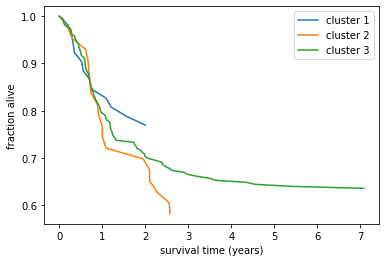

In [37]:
from scipy.cluster.hierarchy import fcluster
n_clusters = 3
threshold_distance = (yc[-n_clusters, 2] + yc[-n_clusters+1, 2]) / 2
clusters = fcluster(yc, threshold_distance, 'distance')

plot_cluster_survival_curves(clusters, data_table.columns, patients)

The clustering of gene expression profiles appears to have identified a
higher-risk subtype of melanoma (cluster 2).

The TCGA study backs this claim up with a more robust clustering and
statistical testing. This is indeed only the latest study to show such a
result, with others identifying subtypes of leukemia (blood cancer), gut
cancer, and more. 

## Let's see if we can do better with a NN

Recall Data Structures

In [38]:
data_table.columns

Index(['00624286-41dd-476f-a63b-d2a5f484bb45', 'TCGA-FS-A1Z0', 'TCGA-D9-A3Z1',
       '02c76d24-f1d2-4029-95b4-8be3bda8fdbe', 'TCGA-EB-A51B', 'TCGA-D3-A1Q3',
       'TCGA-FR-A44A', 'TCGA-EE-A17Z', 'TCGA-D3-A51G', 'TCGA-D3-A51E',
       ...
       'TCGA-D9-A149', 'TCGA-EE-A3AG', 'TCGA-D9-A4Z2', 'TCGA-EB-A4OZ',
       'TCGA-EE-A3J4', 'TCGA-FS-A1ZM', 'TCGA-D3-A5GS', 'TCGA-EB-A3XF',
       'TCGA-EE-A2GE', 'ff7431a9-243a-4651-80bb-096379925bbe'],
      dtype='object', length=375)

In [39]:
patients.index.unique()

Index(['TCGA-BF-A1PU', 'TCGA-BF-A1PV', 'TCGA-BF-A1PX', 'TCGA-BF-A1PZ',
       'TCGA-BF-A1Q0', 'TCGA-BF-A3DJ', 'TCGA-BF-A3DL', 'TCGA-BF-A3DM',
       'TCGA-BF-A3DN', 'TCGA-BF-A5EO',
       ...
       'TCGA-GN-A265', 'TCGA-GN-A266', 'TCGA-GN-A267', 'TCGA-GN-A268',
       'TCGA-GN-A269', 'TCGA-GN-A26A', 'TCGA-GN-A26C', 'TCGA-GN-A26D',
       'TCGA-HR-A5NC', 'TCGA-IH-A3EA'],
      dtype='object', length=331)

###### Data Matching and Preparation

Let's match data rows (i.e. genes)

In [40]:
matched_index = pd.Index.intersection(data_table.index, gene_info.index)

Let's now match patiences (i.e. columns)

In [41]:
matched_patients = pd.Index.intersection(patients.index, 
                                         data_table.columns)

In [42]:
counts_genes = data_table.loc[matched_index][matched_patients]

In [43]:
counts_genes.shape

(20500, 331)

In [44]:
matched_patients.shape

(331,)

In [45]:
patients.head(n=10)

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0
TCGA-BF-A3DJ,UV signature,keratin,NaN,NaN
TCGA-BF-A3DL,UV signature,keratin,NaN,NaN
TCGA-BF-A3DM,UV signature,MITF-low,NaN,NaN
TCGA-BF-A3DN,UV signature,MITF-low,NaN,NaN
TCGA-BF-A5EO,UV signature,keratin,NaN,NaN


In [46]:
patients[patients['melanoma-dead'] == 1].shape

(114, 4)

In [47]:
data_counts = np.asarray(counts_genes, dtype=int)

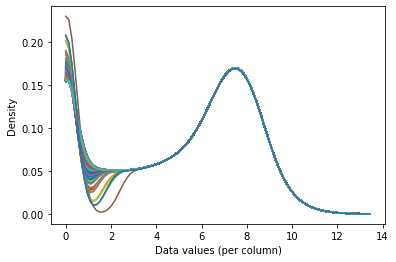

In [48]:
log_data_counts_norm = quantile_norm_log(data_counts)

plot_col_density(log_data_counts_norm)

In [49]:
log_data_counts_norm.shape

(20500, 331)

In [50]:
X_data = log_data_counts_norm.T

In [51]:
X_data.shape

(331, 20500)

In [52]:
counts_genes.head()

,TCGA-BF-A1PU,TCGA-BF-A1PV,TCGA-BF-A1PX,TCGA-BF-A1PZ,TCGA-BF-A1Q0,TCGA-BF-A3DJ,TCGA-BF-A3DL,TCGA-BF-A3DM,TCGA-BF-A3DN,TCGA-BF-A5EO,...,TCGA-GN-A264,TCGA-GN-A265,TCGA-GN-A266,TCGA-GN-A267,TCGA-GN-A268,TCGA-GN-A26A,TCGA-GN-A26C,TCGA-GN-A26D,TCGA-HR-A5NC,TCGA-IH-A3EA
A1BG,543.31,725.57,820.12,1389.56,931.40,674.00,776.96,510.27,622.84,970.43,...,585.89,660.19,406.00,765.00,144.03,225.83,613.71,213.00,612.11,377.55
A1CF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A2BP1,4.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00
A2LD1,502.76,203.68,361.61,258.20,192.33,269.71,203.76,427.56,486.05,142.41,...,143.16,307.50,325.29,350.29,429.83,124.03,274.50,462.39,227.34,102.83
A2ML1,24.00,2.00,9428.00,88.00,16.00,2857.00,1.00,1.00,12.00,1276.00,...,8.00,0.00,0.00,6.00,3.00,1.00,2.00,1.00,2517.00,0.00


In [53]:
counts_genes.shape

(20500, 331)

In [54]:
counts_genes.columns.shape

(331,)

In [55]:
y = patients.loc[counts_genes.columns.unique()]['melanoma-dead']

In [56]:
y = y.fillna(0.0)

In [57]:
y.shape

(331,)

In [58]:
y = np.asarray(y, dtype=int)

In [59]:
y.shape

(331,)

In [60]:
X_data.shape

(331, 20500)

In [61]:
stratify = patients.loc[counts_genes.columns.unique()]['original-clusters']

In [62]:
stratify.shape

(331,)

In [63]:
stratify.unique()

array(['keratin', 'immune', 'MITF-low', nan], dtype=object)

In [64]:
strat_labels = stratify.replace({'keratin': 0, 'immune': 1, 'MITF-low': 2})

In [65]:
strat_labels = strat_labels.fillna(3)

In [66]:
strat_labels.shape

(331,)

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, 
                                                    test_size=0.2, random_state=7,
                                                    stratify=strat_labels)

In [199]:
X_train.shape, X_test.shape

((264, 20500), (67, 20500))

In [200]:
y_train.shape, y_test.shape

((264,), (67,))

In [201]:
import torch
from torch import nn

In [202]:
in_features = X_train.shape[1]

In [203]:
in_features

20500

In [211]:

model = nn.Sequential(
    nn.Linear(in_features, 1000),
    nn.Tanh(),
    nn.Linear(1000, 250),
    nn.Tanh(),
    nn.Linear(250, 1),
)

criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.001)

In [212]:
X_train.shape

(264, 20500)

In [213]:
from torch.utils.data import TensorDataset, DataLoader

training_set = TensorDataset(torch.from_numpy(X_train), 
                             torch.from_numpy(y_train))
training_load = DataLoader(training_set, shuffle=True, batch_size=4, drop_last=False)

In [214]:
test_set = TensorDataset(torch.from_numpy(X_test), 
                         torch.from_numpy(y_test))
test_load = DataLoader(test_set, shuffle=False, batch_size=4, drop_last=False)

In [215]:
## Test one batch first

b = next(iter(training_load))
b[0].shape, b[1].shape

(torch.Size([4, 20500]), torch.Size([4]))

In [216]:
for e in range(50):
    total_train_loss = 0
    for b, batch in enumerate(training_load):
        X_batch, y_batch = batch
        y_pred = model(X_batch.float())
        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        total_train_loss += loss.item() * len(X_batch)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimiser.zero_grad() 
        # Activate Backward Prop.
        loss.backward()
        # Trigger a step for the optimiser
        optimiser.step()
        
    print('{} --> {}'.format(e, total_train_loss))

0 --> 176.10435724258423
1 --> 173.65384232997894
2 --> 172.12103974819183
3 --> 173.06994605064392
4 --> 173.34422600269318
5 --> 173.68232905864716
6 --> 172.8933163881302
7 --> 171.59396135807037
8 --> 173.6289005279541
9 --> 172.4046837091446
10 --> 172.88735508918762
11 --> 172.3186354637146
12 --> 170.99208974838257
13 --> 169.82033050060272
14 --> 171.56243443489075
15 --> 171.66411757469177
16 --> 171.43586778640747
17 --> 171.85993230342865
18 --> 171.95491456985474
19 --> 172.89727580547333
20 --> 169.7747312784195
21 --> 173.21084773540497
22 --> 168.39640939235687
23 --> 170.31154692173004
24 --> 168.49036848545074
25 --> 170.03282010555267
26 --> 172.3081327676773
27 --> 168.80214774608612
28 --> 169.20891749858856
29 --> 168.97060024738312
30 --> 168.4845130443573
31 --> 167.9425756931305
32 --> 166.50173324346542
33 --> 169.34905236959457
34 --> 166.39438426494598
35 --> 169.29058521986008
36 --> 170.3283338546753
37 --> 163.87977182865143
38 --> 167.37144017219543
39 --

In [217]:
acc_test = 0.0
model.eval()
with torch.no_grad():
    for s, (X_batch, y_batch) in enumerate(test_load):
        y_tpred = model(X_batch.float())
        y_pred_cat = torch.round(torch.sigmoid(y_tpred))
        acc_test += ((y_pred_cat == y_batch).sum()).float()
print(acc_test/len(test_set))

tensor(2.8209)
